# Lotka Volterra 

The Lotka-Volterra (aka Prey-Predator) model is a model that describes the evolution of the population of two species (e.g. foxes and rabbits):

$\frac{du}{dt} =\alpha u - \beta uv $  

$\frac{dv}{dt} = -\gamma v + \delta buv $

- u(t) population size of the prey species (rabbits)
- v(t) population size of the predator species (foxes)

$\alpha, \beta, \gamma, \delta \geq 0$
- $\alpha$  prey growth/reproduction rate
- $\beta$ prey shrinkage/death rate
- $\gamma$ predator shrinakge/death rate
- $\delta$ predators born per prey

In [1]:
#See also https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html
#
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import numpy as np

import sbibm
from sbibm.algorithms import snpe
from sbibm.metrics import c2st
from sbi.analysis import pairplot, marginal_plot

from loss_calibration.classifier import FeedforwardNN, train
from loss_calibration.lotka_volterra import posterior_ratio_given_samples, plot_observations, load_data, generate_data
from loss_calibration.loss import StepLoss_weighted, LinearLoss_weighted
from loss_calibration.utils import prepare_for_training


## Task, Prior, Simulator

Use implementation provided by sbibm.

In [ ]:
task = sbibm.get_task('lotka_volterra')
prior = task.get_prior()
simulator = task.get_simulator()

In [ ]:
print(task.dim_data,              # dimensionality data, here: 20
      task.dim_parameters,        # dimensionality parameters, here: 4
      task.num_observations)      # number of different observations x_o available, here: 10

20 4 10


Take a look at the observations

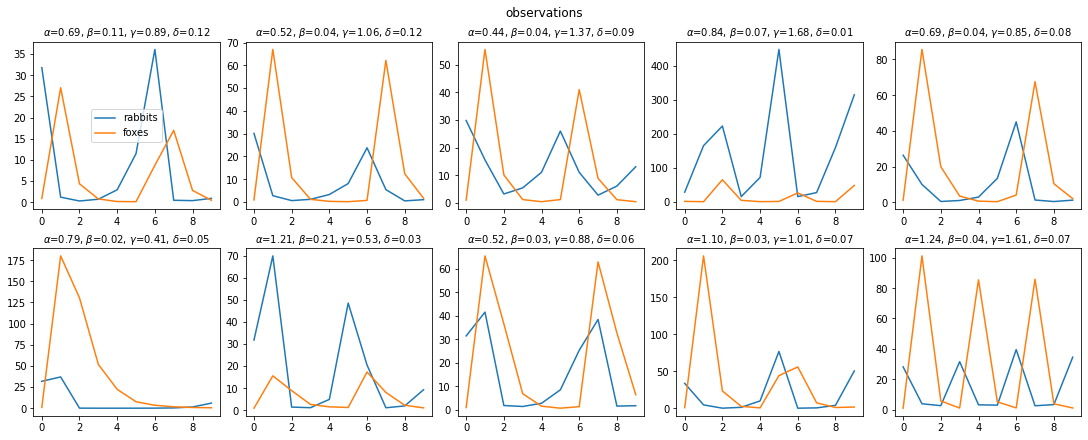

In [ ]:
plot_observations(2,5)

Check out prior

In [6]:
# priors defined as Log Normal with 
mu_p1 = -0.125
mu_p2 = -3.0
sigma_p = 0.5

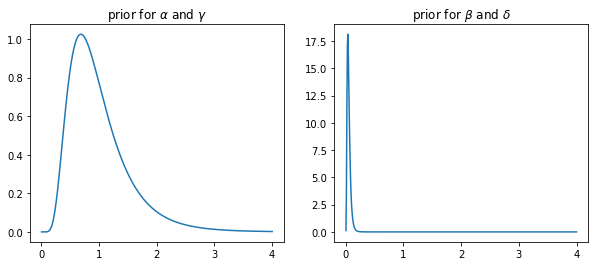

In [7]:
ths  = torch.linspace(0,4, 500)
log_normal1 = torch.distributions.LogNormal(mu_p1, sigma_p)
log_normal2 = torch.distributions.LogNormal(mu_p2, sigma_p)

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(ths, torch.exp(log_normal1.log_prob(ths)))
axes[0].set_title(r'prior for $\alpha$ and $\gamma$')
axes[1].plot(ths, torch.exp(log_normal2.log_prob(ths)))
axes[1].set_title(r'prior for $\beta$ and $\delta$')
plt.show()

Simulator is given by ODE described above

## True Posterior

given by reference samples for each observation

## NPE

In [8]:
reference_samples = [task.get_reference_posterior_samples(num_observation=n+1) for n in range(10)]

train_npe=False

num_samples=5000
num_sim = 100_000

if train_npe:  
    # since NPE is amoritzed, return the posterior and use it for all observations
    npe_posterior, posterior_samples_obs, _ = snpe(task=task, num_samples=num_samples, num_observation=1, num_simulations=num_sim, num_rounds=1, return_posterior=True)
    torch.save(npe_posterior, f"./results/lotka_volterra/npe_posterior_sim{num_sim//1000}k.pt")
else: 
    npe_posterior = torch.load(f"./results/lotka_volterra/npe_posterior_sim{num_sim//1000}k.pt")

In [9]:
num_samples = 10000
posterior_samples = []
for n in range(10):
    samples = npe_posterior.sample((num_samples,), x = task.get_observation(n+1))
    posterior_samples.append(samples)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/mgorecki/.virtualenvs/bm_venv/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  outputs, _ = torch.triangular_solve(


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
#c2st_accuracy = c2st(reference_samples[0], posterior_samples[0])
#c2st_accuracy

In [11]:
def _format_axis(ax, xhide=True, yhide=True, xlabel="", ylabel="", tickformatter=None):
    for loc in ["right", "top", "left", "bottom"]:
        ax.spines[loc].set_visible(False)
    if xhide:
        ax.set_xlabel("")
        ax.xaxis.set_ticks_position("none")
        ax.xaxis.set_tick_params(labelbottom=False)
    if yhide:
        ax.set_ylabel("")
        ax.yaxis.set_ticks_position("none")
        ax.yaxis.set_tick_params(labelleft=False)
    if not xhide:
        ax.set_xlabel(xlabel)
        ax.xaxis.set_ticks_position("bottom")
        ax.xaxis.set_tick_params(labelbottom=True)
        if tickformatter is not None:
            ax.xaxis.set_major_formatter(tickformatter)
        ax.spines["bottom"].set_visible(True)
    if not yhide:
        ax.set_ylabel(ylabel)
        ax.yaxis.set_ticks_position("left")
        ax.yaxis.set_tick_params(labelleft=True)
        if tickformatter is not None:
            ax.yaxis.set_major_formatter(tickformatter)
        ax.spines["left"].set_visible(True)
    return ax

### Pairplots

observation 1


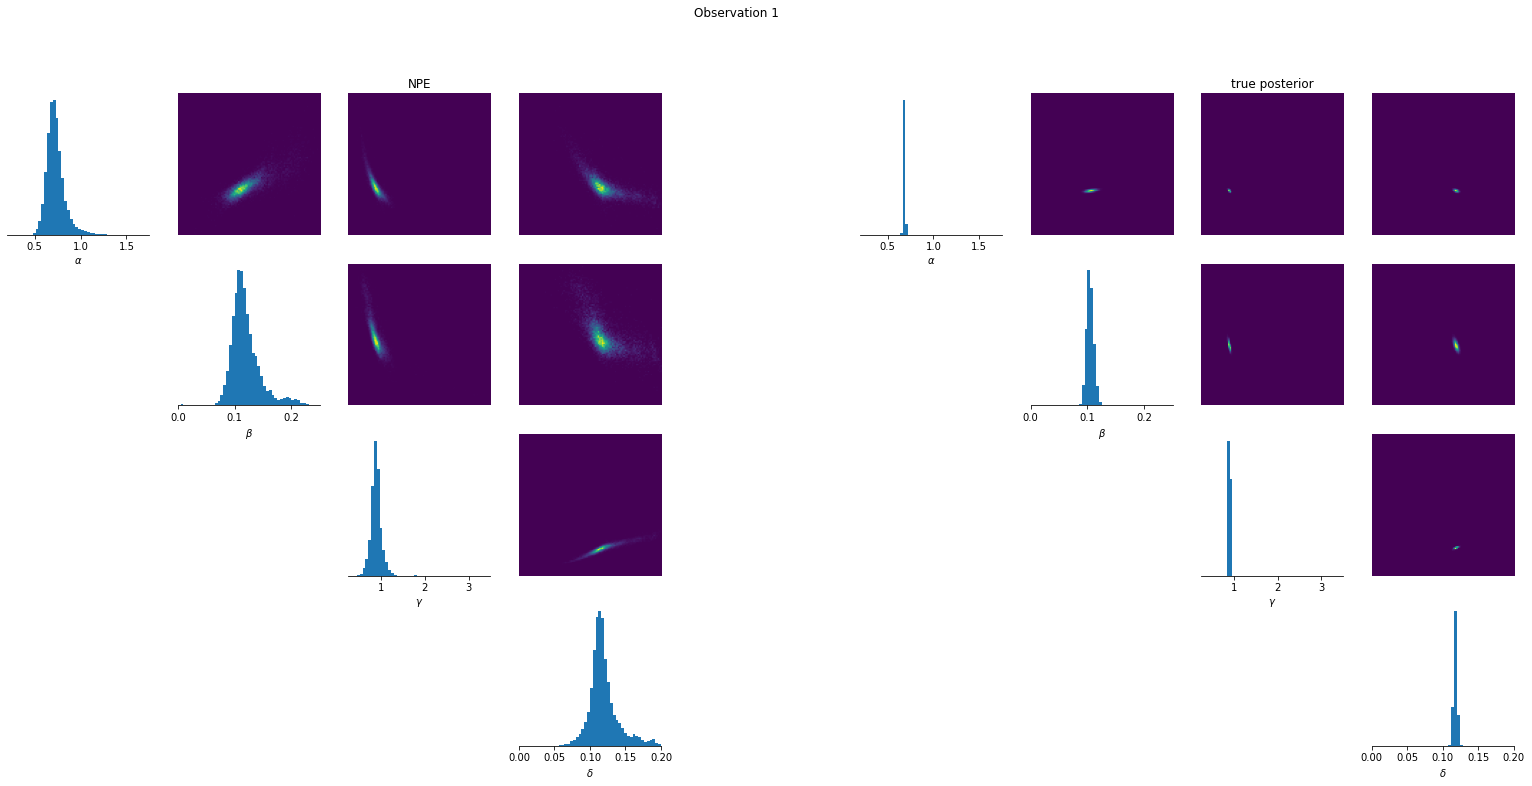

observation 2


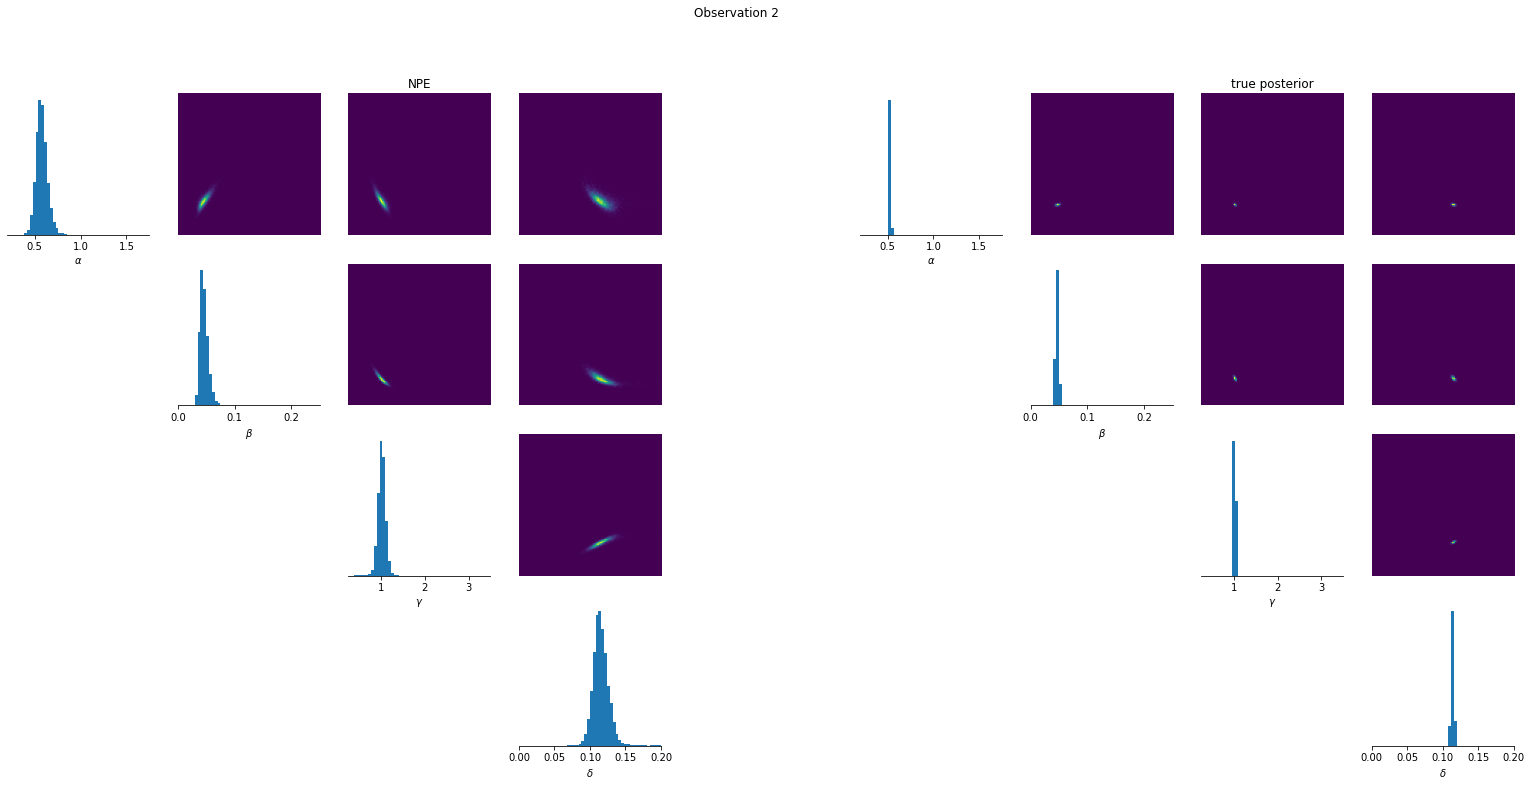

observation 3


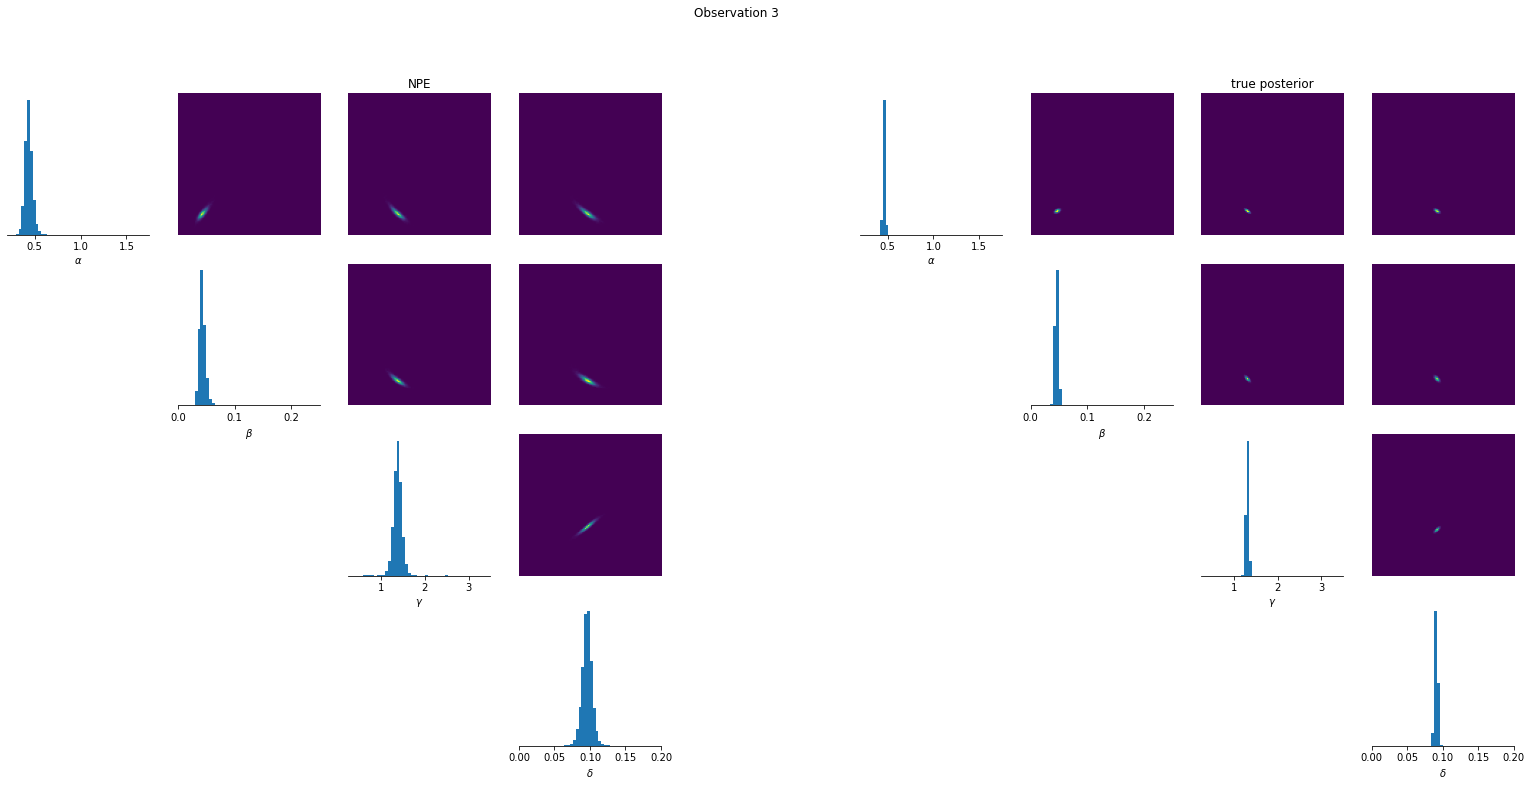

observation 4


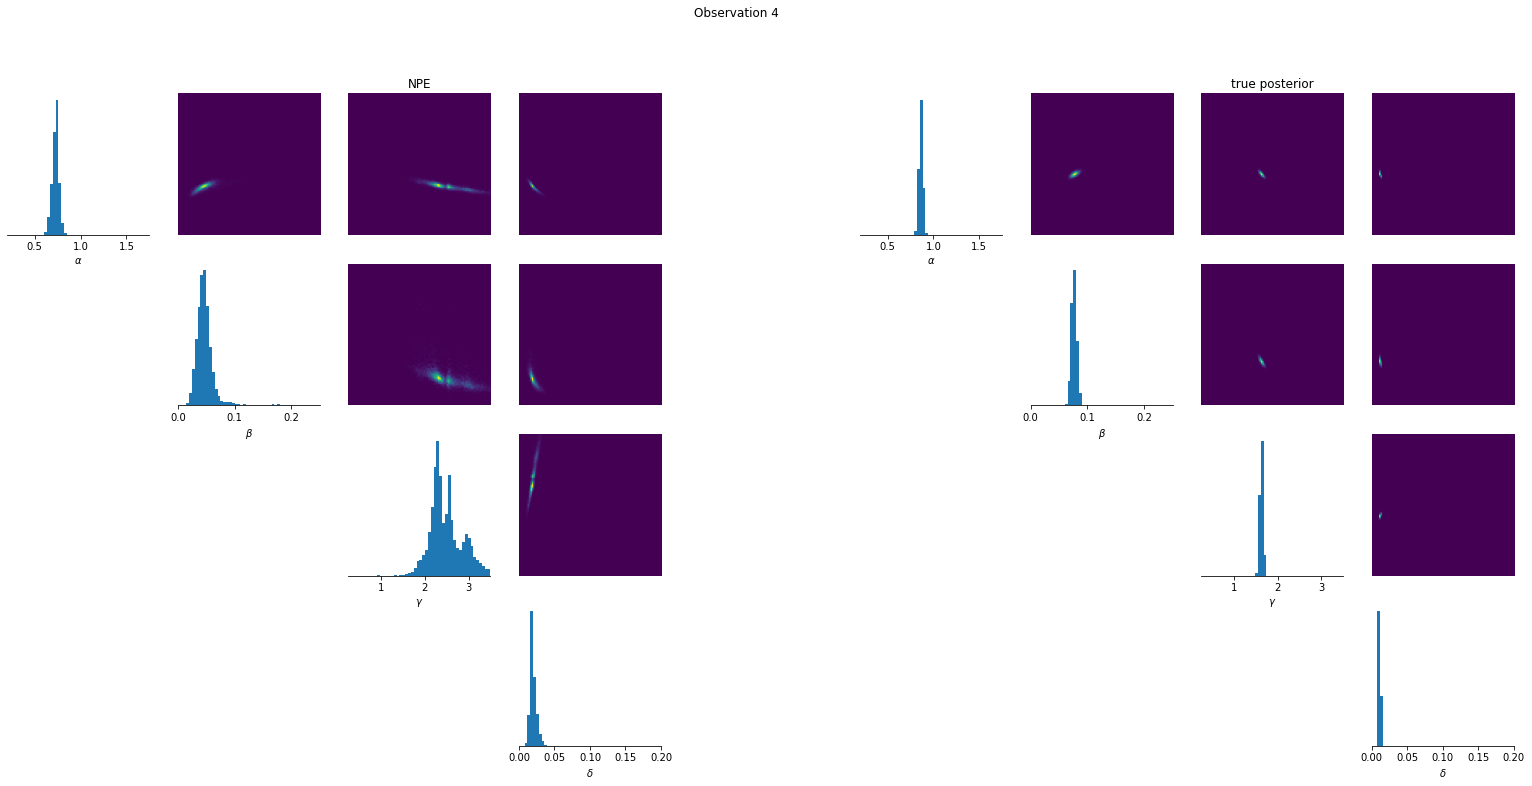

observation 5


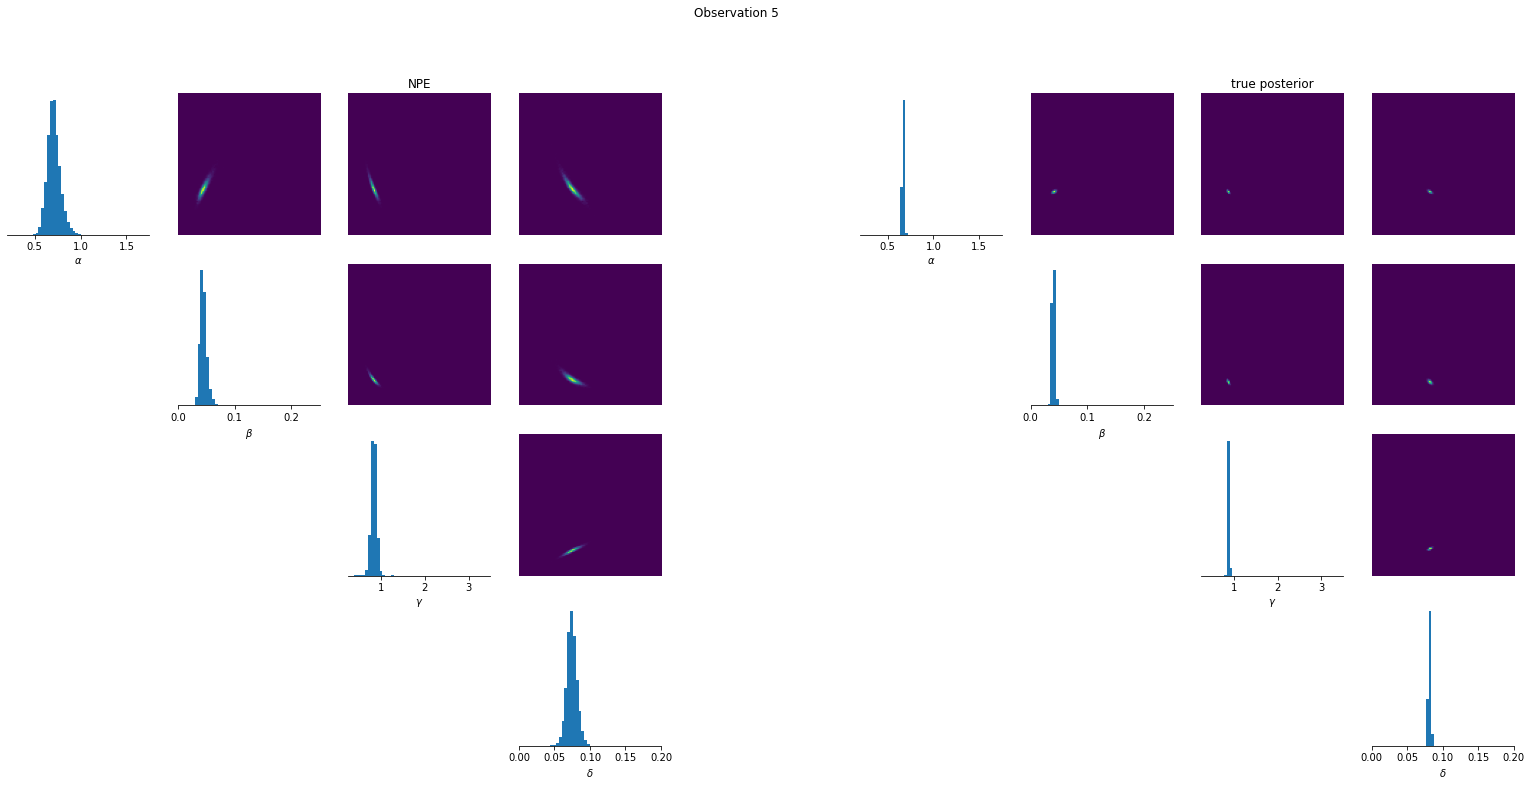

observation 6


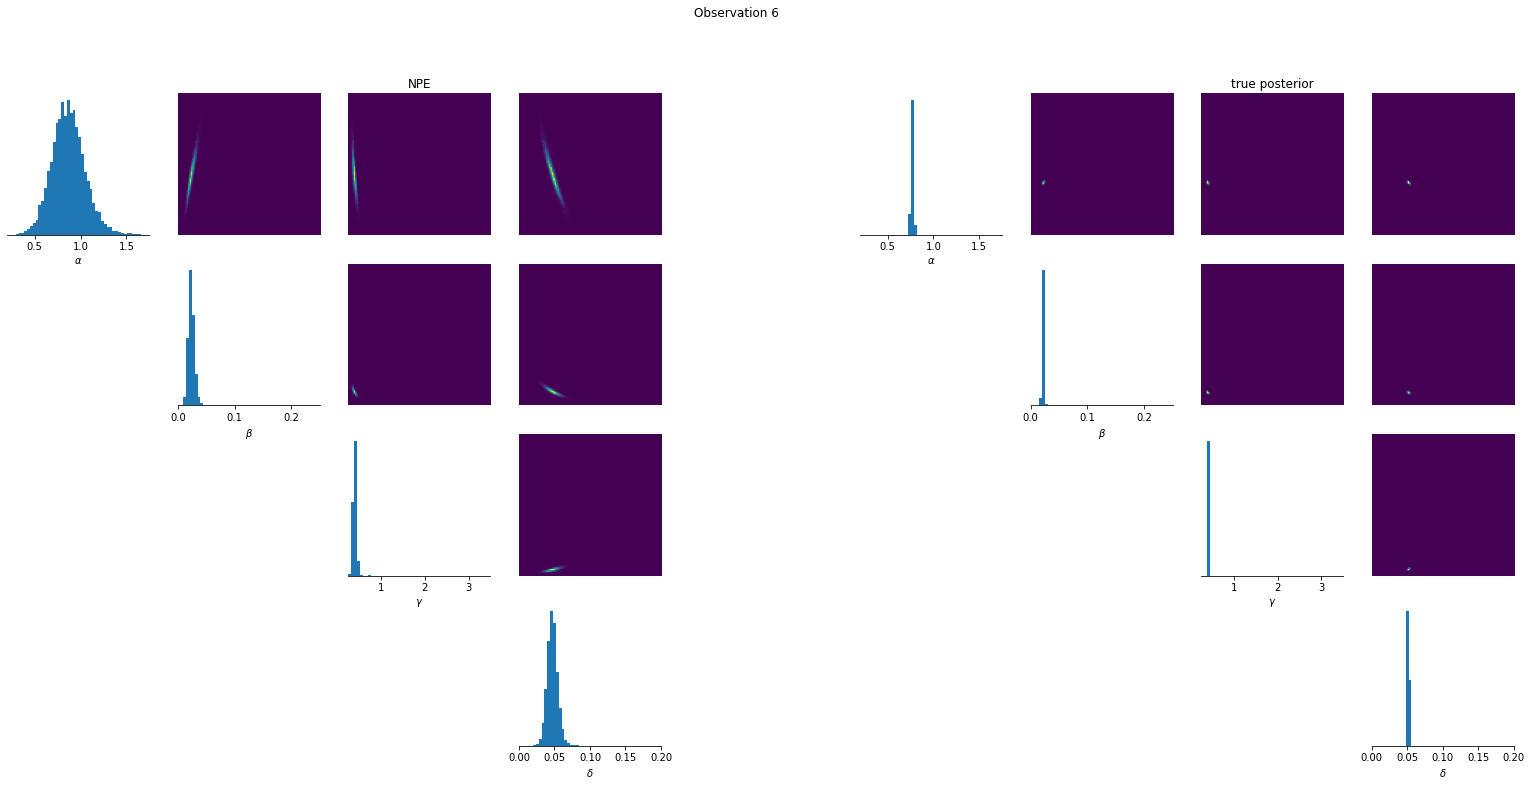

observation 7


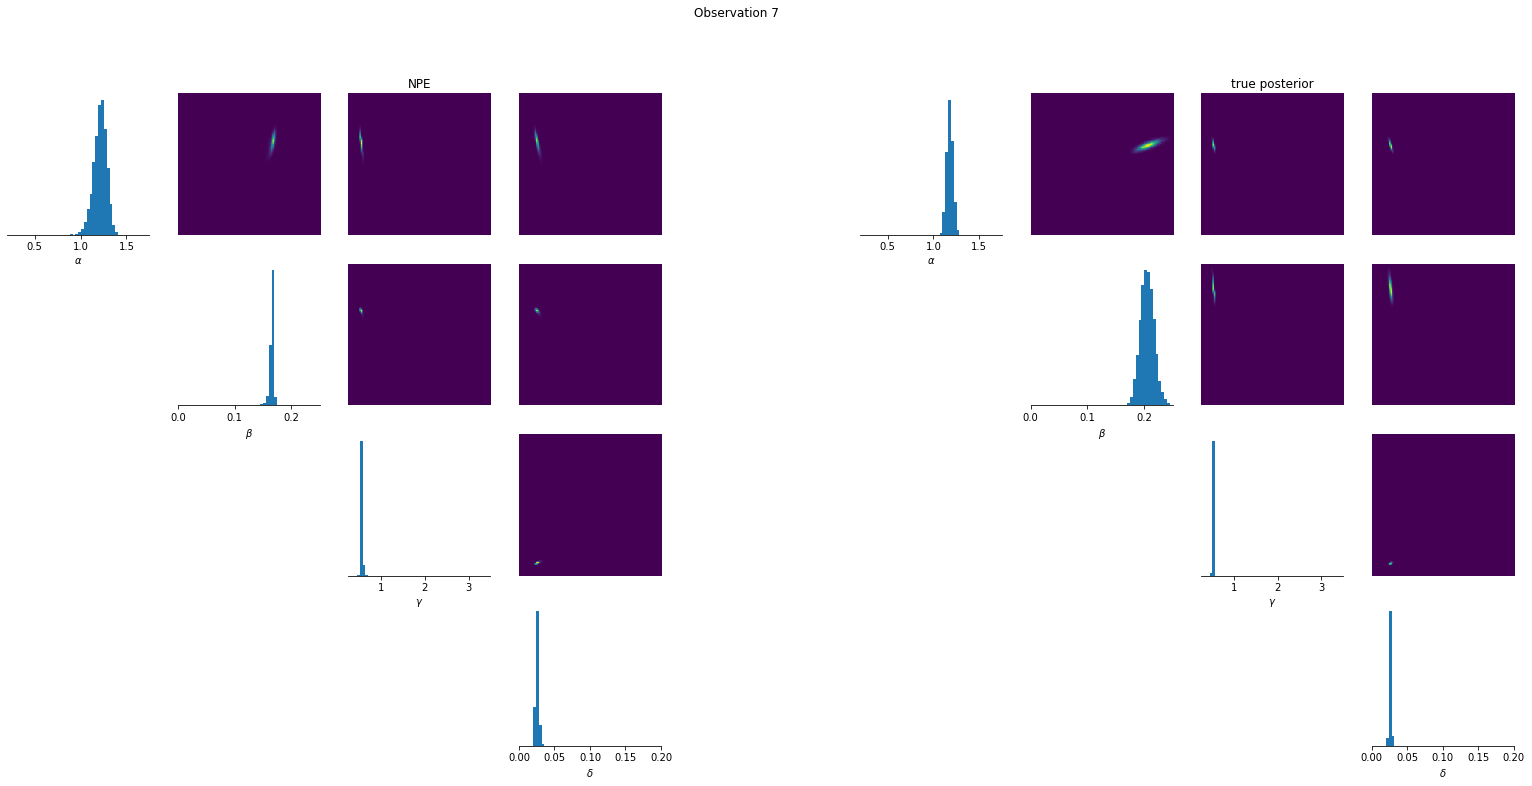

observation 8


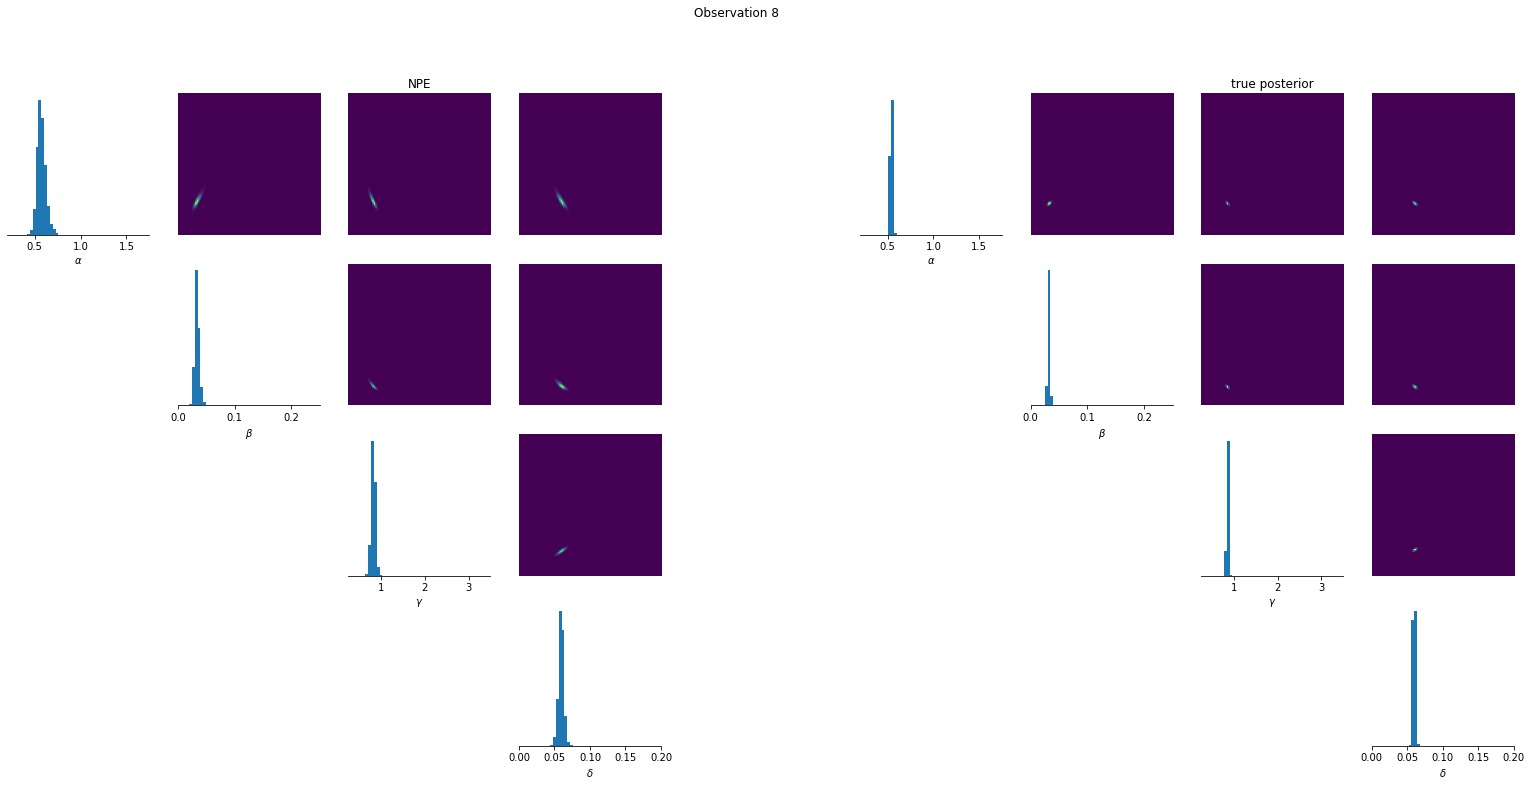

observation 9


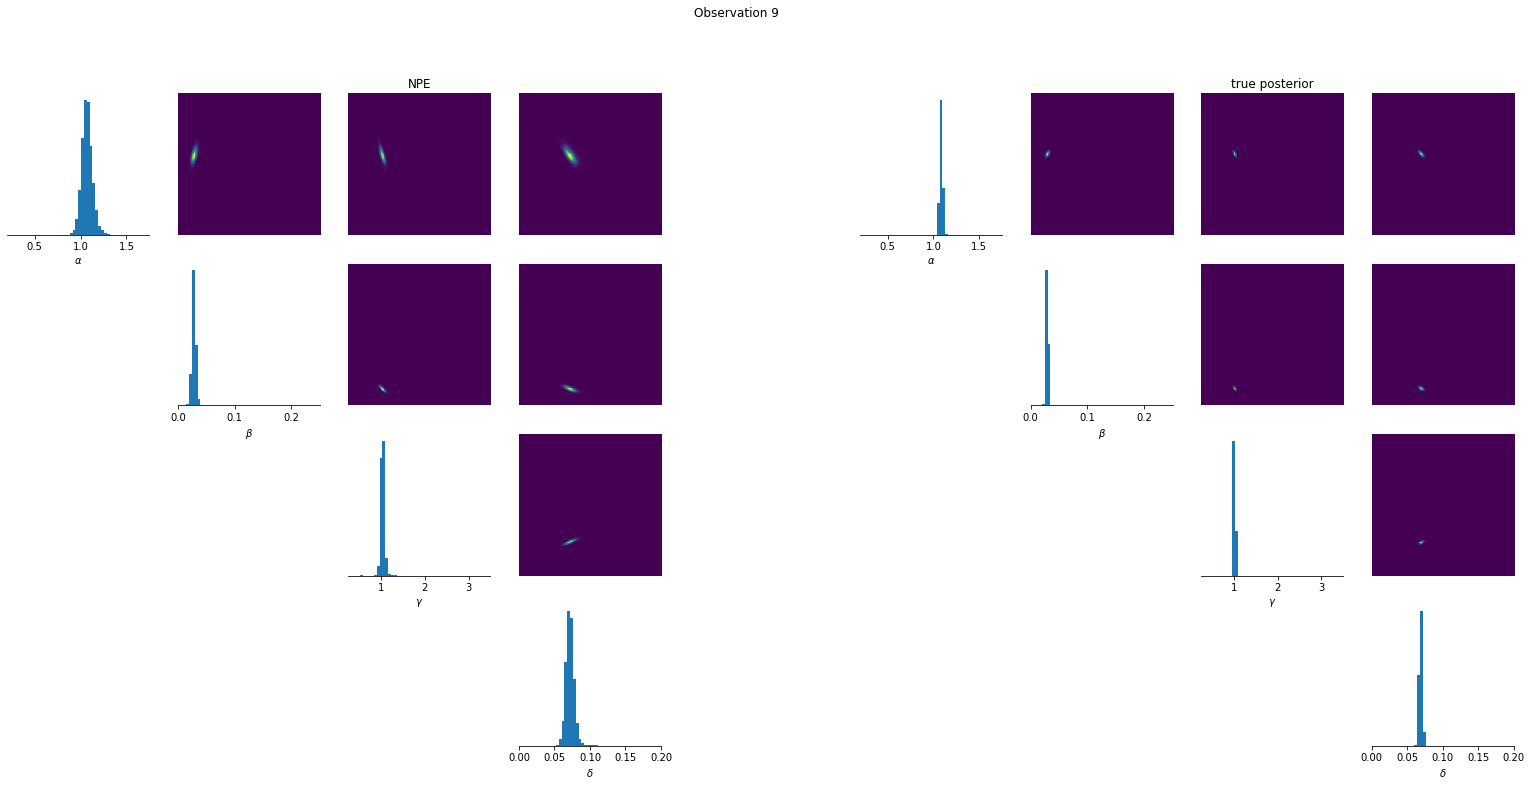

observation 10


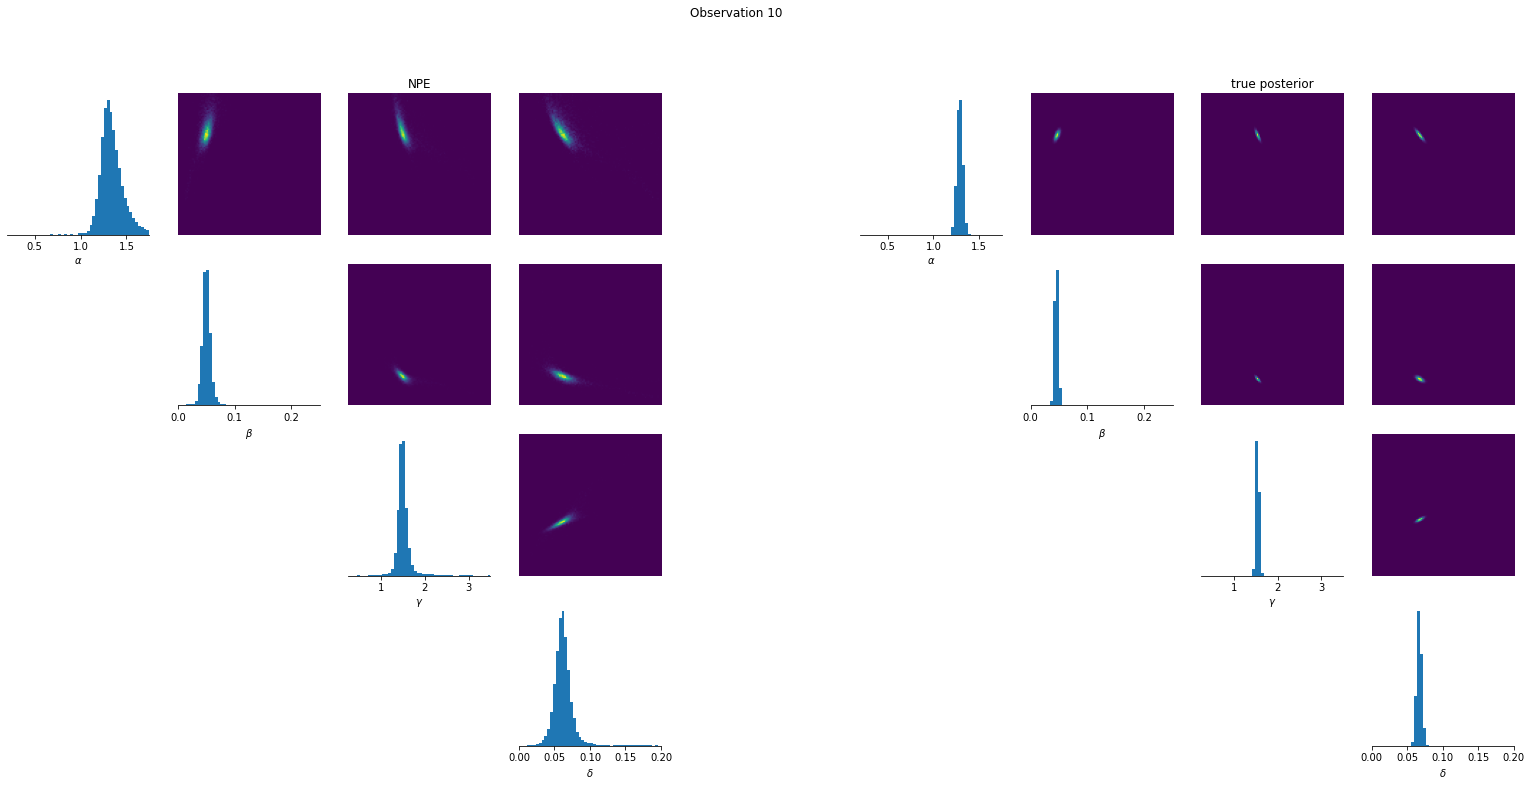

In [12]:
for obs in range(1,11):
    print('observation', obs)
    limits = [[0.2, 1.75], [0.0, 0.25], [0.25, 3.5], [0.0, 0.2]]
    limit_dict = {"1": [[0.5, 1.0], [0.05, 0.2], [0.5, 1.25], [0.075, 0.2]],
                  "2": [[0.4, 0.8], [0.025, 0.075], [0.5, 1.5], [0.075, 0.15]],
                  "3": [[0.3, 0.6], [0.025, 0.07], [1.0, 1.75], [0.075, 0.125]],
                  "4": [[0.6, 1.0], [0.0, 0.1], [1.5, 3.5], [0.0, 0.04]],
                  "5": [[0.4, 1.0], [0.025, 0.075], [0.5, 1.25], [0.05, 0.1]],
                  "6": [[0.2, 1.5], [0.0, 0.05], [0.2, 0.6], [0.025, 0.075]],
                  "7": [[0.9, 1.5], [0.15, 0.25], [0.45, 0.65], [0.02, 0.04]],
                  "8": [[0.4, 0.75], [0.02, 0.05], [0.6, 1.0], [0.04, 0.075]],
                  "9": [[0.9, 1.25], [0.02, 0.04], [0.9, 1.2], [0.05, 0.1]],
                  "10": [[1.0, 1.75], [0.025, 0.075], [1.0, 2.0], [0.025, 0.125]],}
    #limits = limit_dict[str(obs)]
    labels=[r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
    dims = 4 
    rows = 4
    cols = 9
    fig, axes = plt.subplots(rows,cols,figsize=(27,12))
    fig.suptitle(f'Observation {obs}')
    axes[0,2].set_title('NPE')
    axes[0,7].set_title('true posterior')
    for r in range(rows):
        for c in range(cols):
            # diagonals
            if r==c: 
                _format_axis(axes[r,c], xhide=False, xlabel=labels[c], yhide=True,)
                _format_axis(axes[r,c+dims+1], xhide=False, xlabel=labels[c], yhide=True,)
                axes[r,c].hist(posterior_samples[obs-1][:,c%dims], bins=50, range=[limits[r][0], limits[r][1]])
                axes[r,c].set_xlim((limits[c][0], limits[c][1]))
                axes[r,c+dims+1].hist(reference_samples[obs-1][:,c%dims], bins=50, range=[limits[r][0], limits[r][1]])
                axes[r,c+dims+1].set_xlim((limits[c][0], limits[c][1]))
            elif (c == 4) or (r>c) or (r>(c%5)): 
                axes[r,c].axis("off")
                continue
            # off-diagonals
            # NPE
            elif c < 4:
                _format_axis(axes[r,c], xhide=True, yhide=True,)
                hist, xedges, yedges = np.histogram2d(posterior_samples[obs-1][:,c%dims].numpy(), 
                                                    posterior_samples[obs-1][:,r%dims].numpy(), 
                                                    bins=100, 
                                                    range=[[limits[c][0], limits[c][1]],[limits[r][0], limits[r][1]],],)
                axes[r,c].imshow(hist.T, origin="lower", extent=[xedges[0],xedges[-1],yedges[0],yedges[-1],], aspect="auto",)
            # True posterior
            elif c > 4 and not r==((c-1)%dims):
                _format_axis(axes[r,c], xhide=True, yhide=True,)
                hist, xedges, yedges = np.histogram2d(reference_samples[obs-1][:,(c-1)%dims].numpy(),
                                                    reference_samples[obs-1][:,r%dims].numpy(), 
                                                    bins=100, 
                                                    range=[[limits[(c-1)%dims][0], limits[(c-1)%dims][1]],[limits[r][0], limits[r][1]],],)
                axes[r,c].imshow(hist.T, origin="lower", extent=[xedges[0],xedges[-1],yedges[0],yedges[-1],], aspect="auto",)
    fig.savefig(f'./results/lotka_volterra/npe_vs_true/npe_vs_true_obs{obs}.pdf')
    fig.savefig(f'./results/lotka_volterra/npe_vs_true/npe_vs_true_obs{obs}.jpg')
    plt.show()

### Marginal Plots

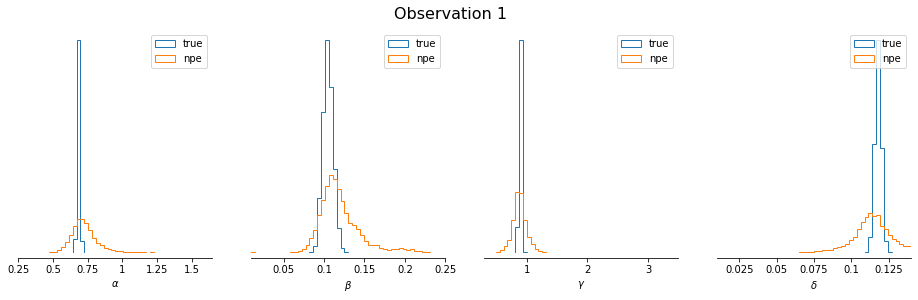

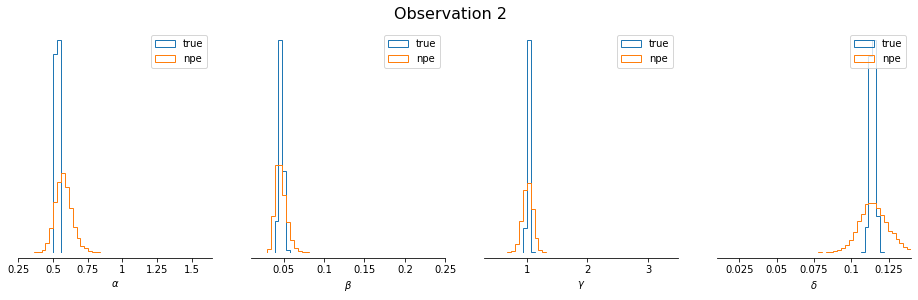

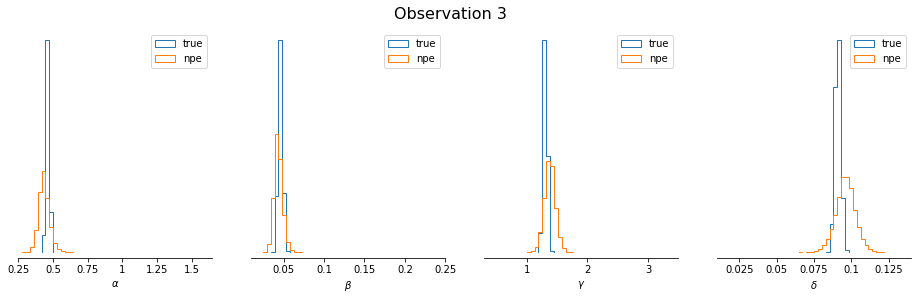

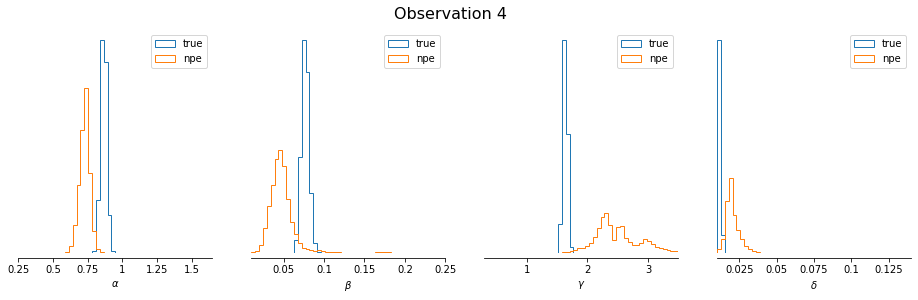

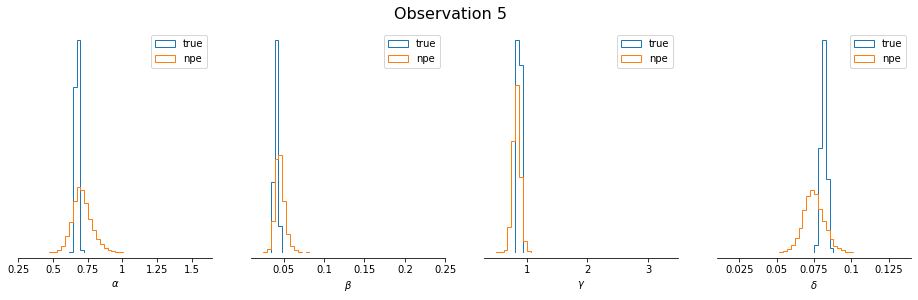

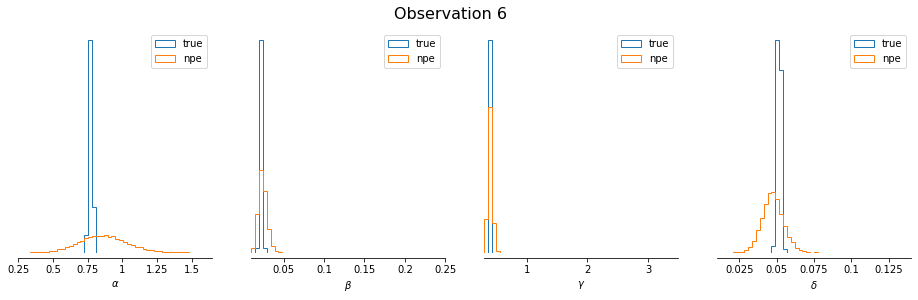

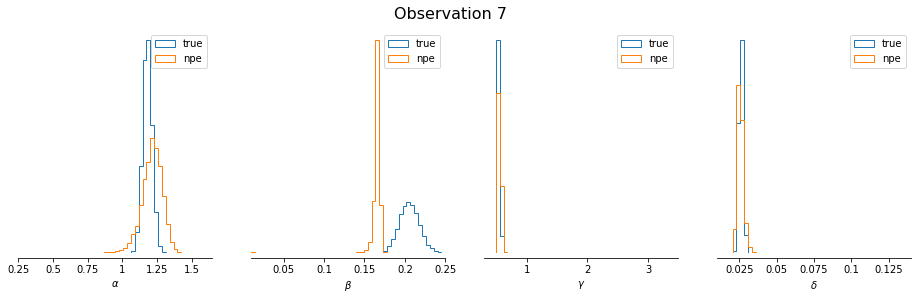

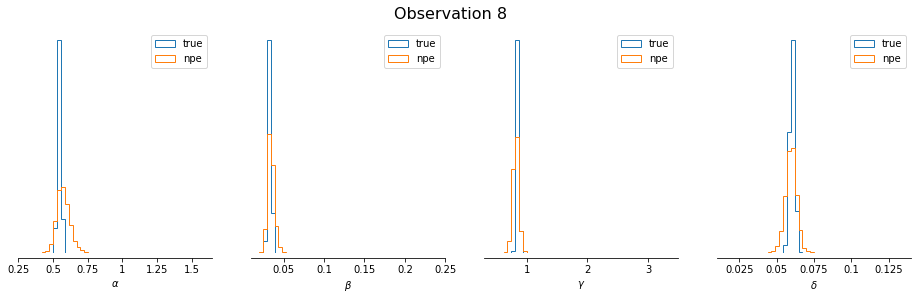

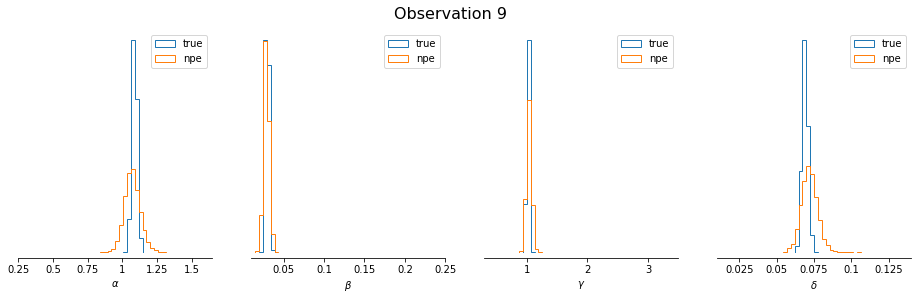

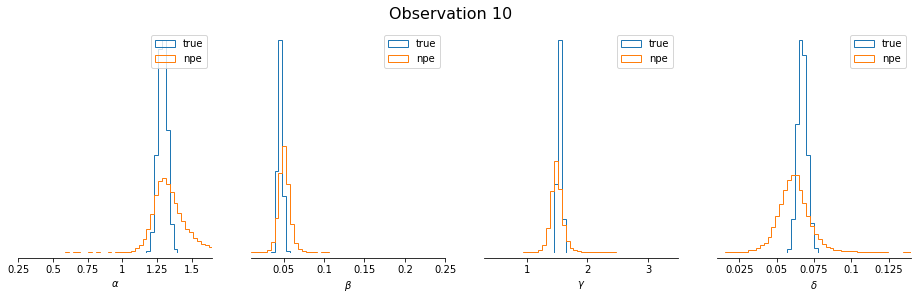

In [13]:
for obs in range(1,11):
    limit_dict = {"1": [[0.5, 1.0], [0.05, 0.2], [0.5, 1.25], [0.075, 0.2]],
                  "2": [[0.4, 0.8], [0.025, 0.075], [0.5, 1.5], [0.075, 0.15]],
                  "3": [[0.3, 0.6], [0.025, 0.07], [1.0, 1.75], [0.075, 0.125]],
                  "4": [[0.6, 1.0], [0.0, 0.1], [1.5, 3.5], [0.0, 0.04]],
                  "5": [[0.4, 1.0], [0.025, 0.075], [0.5, 1.25], [0.05, 0.1]],
                  "6": [[0.2, 1.5], [0.0, 0.05], [0.2, 0.6], [0.025, 0.075]],
                  "7": [[0.9, 1.5], [0.15, 0.25], [0.45, 0.65], [0.02, 0.04]],
                  "8": [[0.4, 0.75], [0.02, 0.05], [0.6, 1.0], [0.04, 0.075]],
                  "9": [[0.9, 1.25], [0.02, 0.04], [0.9, 1.2], [0.05, 0.1]],
                  "10": [[1.0, 1.75], [0.025, 0.075], [1.0, 2.0], [0.025, 0.125]],}
    limits = limit_dict[str(obs)]
    limits = [[0.25, 1.65], [0.01, 0.25], [0.3, 3.5], [0.01, 0.14]]
    marginal_plot([reference_samples[obs-1], posterior_samples[obs-1]], limits=limits, figsize=(16,4), title=f'Observation {obs}', labels=[r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$'], legend=True, labels_samples=['true', 'npe'])
    plt.savefig(f'./results/lotka_volterra/marginal_plots/marginal_plot_obs{obs}.jpg')

## Classifier

### Generate training data $(\theta, x) \sim p(\theta)p(x|\theta)$

In [13]:
load = True
if load: 
    theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data()
else: 
    theta_train, x_train, theta_val, x_val, theta_test, x_test = generate_data()

### Decision Based on NPE Marginal Plots

To see wether the classifier approach works for Lotka Volterra, we explicitly set the treshold and costs such that NPE breaks, i.e. makes the wrong direction for specific observations. 

#### Observation 7 - $\beta=0.18$

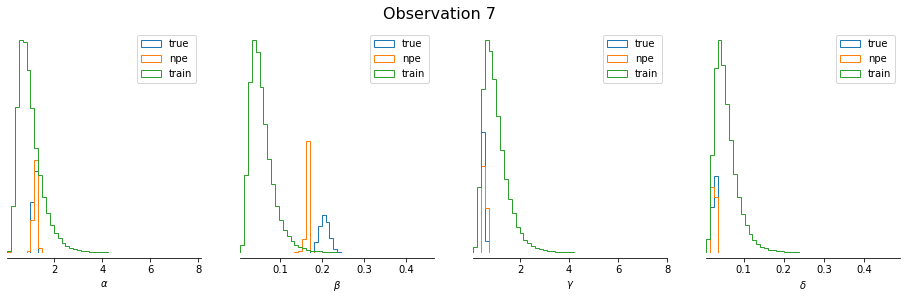

In [15]:
obs = 7
marginal_plot([reference_samples[obs-1], posterior_samples[obs-1], theta_train], #theta_train[torch.logical_and(theta_train[:, 1] > reference_samples[obs-1][:,1].min(),theta_train[:, 1] < reference_samples[obs-1][:,1].max())]],
              #limits=limit_dict[str(obs)],
              figsize=(16,4), 
              title=f'Observation {obs}', 
              labels=[r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$'], 
              legend=True,
              labels_samples=['true', 'npe', 'train'])
plt.show()

In [55]:
# take beta for decisions
T_beta = 0.18
costs = [20.,1.]

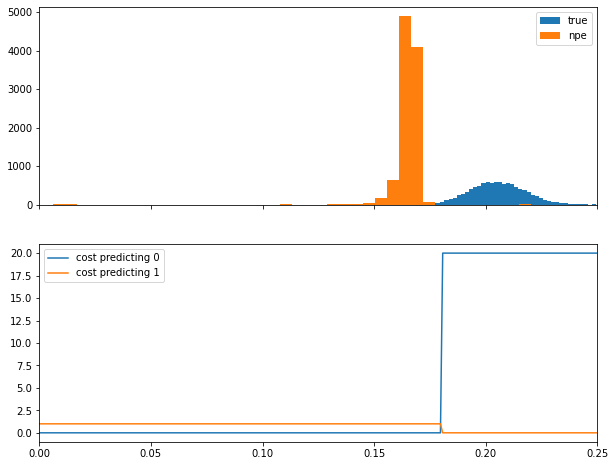

In [56]:
step_loss = StepLoss_weighted(costs, T_beta)

fig, ax = plt.subplots(2,1,figsize=(10,8), sharex=True)
ax[0].hist(reference_samples[6][:,1], bins=50, label='true')
ax[0].hist(posterior_samples[6][:,1], bins = 50, label='npe')
ax[0].legend()
ax[0].set_xlim(0, 0.25)
betas = torch.linspace(0,0.25, 250)
ax[1].plot(betas.numpy(), step_loss(betas, 0), label = 'cost predicting 0')
ax[1].plot(betas.numpy(), step_loss(betas, 1), label = 'cost predicting 1')
ax[1].legend()
ax[1].set_xlim(0, 0.25)
plt.show()

Decisions taken when using the true posterior

Since we only have ten observations and their respective true posterior available, check out the correct decision for them: 

In [100]:
posterior_ratios = []
npe_ratios = []
for n in range(1,11):
    posterior_obs_beta = reference_samples[n-1][:,1]
    posterior_ratio = posterior_ratio_given_samples(posterior_obs_beta, T_beta, costs)
    posterior_ratios.append(posterior_ratio)
    npe_obs_beta = posterior_samples[n-1][:,1]
    npe_ratio = posterior_ratio_given_samples(npe_obs_beta, T_beta, costs)
    npe_ratios.append(npe_ratio)
    print(f"{n}:\ttrue posterior: {posterior_ratio>0.5}\tNPE: {npe_ratio>0.5}")

1:	true posterior: False	NPE: False
2:	true posterior: False	NPE: False
3:	true posterior: False	NPE: False
4:	true posterior: False	NPE: False
5:	true posterior: False	NPE: False
6:	true posterior: False	NPE: False
7:	true posterior: True	NPE: False
8:	true posterior: False	NPE: False
9:	true posterior: False	NPE: False
10:	true posterior: False	NPE: False


train classifier

In [57]:
train_clf = True
if train_clf:
    clf = FeedforwardNN(20, [100, 100, 100], 1)

    clf, loss_values_train, loss_values_val = train(
        clf,
        x_train,
        theta_train[:,1:2],
        x_val,
        theta_val[:,1:2],
        costs,
        T_beta,
        learning_rate=0.001,
        max_num_epochs=5000,
        stop_after_epochs=50,
        model_dir=f"/Users/mgorecki/Documents/Studium/Master/5.Semester/Masterarbeit/loss-calibration/results/lotka_volterra/classifier_obs{obs}",
    )

Converged after 83 epochs. train_loss = 0.01648112	 last_improvement = 47


In [58]:
clf(task.get_observation(7))

tensor([[0.6381]], grad_fn=<SigmoidBackward0>)

In [59]:
clf2 = FeedforwardNN(20, [100, 100, 100], 1)

clf2, loss_values_train, loss_values_val = train(
    clf2,
    x_train,
    theta_train[:,1:2],
    x_val,
    theta_val[:,1:2],
    costs,
    T_beta,
    learning_rate=0.001,
    max_num_epochs=5000,
    stop_after_epochs=50,
    model_dir=f"/Users/mgorecki/Documents/Studium/Master/5.Semester/Masterarbeit/loss-calibration/results/lotka_volterra/classifier_obs{obs}",
)

clf2(task.get_observation(7))

Converged after 141 epochs. train_loss = 0.00905712	 last_improvement = 49


tensor([[0.9722]], grad_fn=<SigmoidBackward0>)

In [82]:
posterior_ratio_given_samples(posterior_obs_beta, T_beta, costs)

tensor(0.9993)

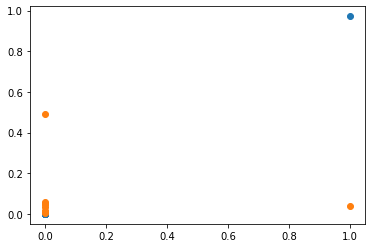

In [106]:
plt.scatter(posterior_ratios, [clf2(task.get_observation(n)).detach().numpy() for n in range(1,11)])
plt.scatter(posterior_ratios, npe_ratios)

#### treshold $\alpha=0.8$

In [35]:
# take alpha for decisions
idx_treshold = 0
treshold = 0.8
costs = [20.,1.]

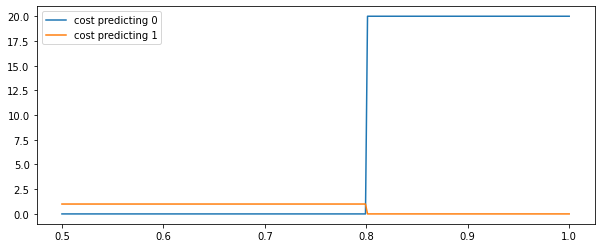

In [36]:
step_loss = StepLoss_weighted(costs, treshold)

fig, ax = plt.subplots(1,1,figsize=(10,4), sharex=True)
alphas = torch.linspace(0.5,1, 250)
ax.plot(alphas.numpy(), step_loss(alphas, 0), label = 'cost predicting 0')
ax.plot(alphas.numpy(), step_loss(alphas, 1), label = 'cost predicting 1')
ax.legend()
plt.show()

Decisions taken when using the true posterior

Since we only have ten observations and their respective true posterior available, check out the correct decision for them: 

In [37]:
posterior_ratios = []
npe_ratios = []
for n in range(1,11):
    posterior_obs_alpha = reference_samples[n-1][:,idx_treshold]
    posterior_ratio = posterior_ratio_given_samples(posterior_obs_alpha, treshold, costs)
    posterior_ratios.append(posterior_ratio)
    npe_obs_alpha = posterior_samples[n-1][:,idx_treshold]
    npe_ratio = posterior_ratio_given_samples(npe_obs_alpha, treshold, costs)
    npe_ratios.append(npe_ratio)
    print(f"{n}:\ttrue posterior: {posterior_ratio>0.5}\tNPE: {npe_ratio>0.5}")
print(f"Accuracy NPE: {((torch.tensor(posterior_ratios)>0.5) == (torch.tensor(npe_ratios) > 0.5)).sum()/len(posterior_ratios):.2f}")

1:	true posterior: False	NPE: True
2:	true posterior: False	NPE: False
3:	true posterior: False	NPE: False
4:	true posterior: True	NPE: False
5:	true posterior: False	NPE: True
6:	true posterior: False	NPE: True
7:	true posterior: True	NPE: True
8:	true posterior: False	NPE: False
9:	true posterior: True	NPE: True
10:	true posterior: True	NPE: True
Accuracy NPE: 0.60


train classifier

In [38]:
architectures = [[50,50], [50,50,50], [100,100], [100,100,100]]
seed = 123
torch.manual_seed(seed)
train_clf = True
if train_clf:
    base_dir = './results/lotka_volterra/classifier_alpha'
    model_dir = prepare_for_training(base_dir,treshold, costs)
    clf = FeedforwardNN(20, [100, 100, 100], 1)

    clf, loss_values_train, loss_values_val = train(
        clf,
        x_train,
        theta_train[:,idx_treshold: idx_treshold+1],
        x_val,
        theta_val[:,idx_treshold: idx_treshold+1],
        costs,
        treshold,
        learning_rate=0.001,
        max_num_epochs=5000,
        stop_after_epochs=100,
        model_dir=model_dir,
        seed=seed
    )

Created directory ./results/lotka_volterra/classifier_alpha/2022-06-27T17_14_46_t0_8_c20_1.


KeyboardInterrupt: 

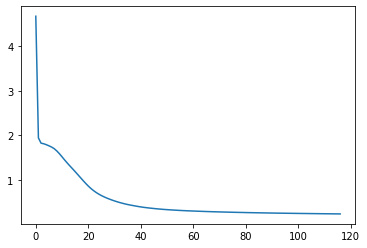

In [40]:
m = torch.load("./results/lotka_volterra/classifier_alpha/2022-06-25T11_05_03_t0_8_c20_1/best_model.pt")
plt.plot(m["training_losses"])

In [48]:
#clf = FeedforwardNN(20, [100, 100, 100], 1)
#clf.load_state_dict(m['state_dict'])

<All keys matched successfully>

In [57]:
clf_predictions = []
for n in range(1,11):
    pred = clf(task.get_observation(n).squeeze()).detach().item()
    clf_predictions.append(pred)
    print(f"{n}:\ttrue posterior: {posterior_ratios[n-1]:.3f}\t{posterior_ratios[n-1]>0.5}\tNPE: {npe_ratios[n-1]>0.5}\tclf: {pred>0.5}")
print(f"Accuracy NPE: {((torch.tensor(posterior_ratios)>0.5) == (torch.tensor(npe_ratios) > 0.5)).sum()/len(posterior_ratios):.2f}")
print(f"Accuracy classifier: {((torch.tensor(posterior_ratios)>0.5) == (torch.tensor(clf_predictions) > 0.5)).sum()/len(posterior_ratios):.2f}")

1:	true posterior: 0.000	False	NPE: True	clf: False
2:	true posterior: 0.000	False	NPE: False	clf: False
3:	true posterior: 0.000	False	NPE: False	clf: False
4:	true posterior: 1.000	True	NPE: False	clf: False
5:	true posterior: 0.000	False	NPE: True	clf: False
6:	true posterior: 0.124	False	NPE: True	clf: True
7:	true posterior: 1.000	True	NPE: True	clf: True
8:	true posterior: 0.000	False	NPE: False	clf: False
9:	true posterior: 1.000	True	NPE: True	clf: True
10:	true posterior: 1.000	True	NPE: True	clf: True
Accuracy NPE: 0.60
Accuracy classifier: 0.80


: 

PROBLEM: NPE and classifier are not trained on the same training data --> TODO

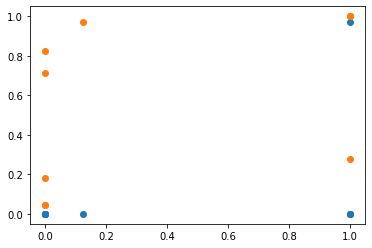

In [155]:
plt.scatter(posterior_ratios, [clf2(task.get_observation(n)).detach().numpy() for n in range(1,11)])
plt.scatter(posterior_ratios, npe_ratios)

In [148]:
posterior_ratios

[tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(1.0000),
 tensor(0.),
 tensor(0.1236),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.)]

In [147]:
[clf2(task.get_observation(n)).detach().numpy() for n in range(1,11)]

[array([[0.00018914]], dtype=float32),
 array([[0.00011062]], dtype=float32),
 array([[0.00010211]], dtype=float32),
 array([[0.00010707]], dtype=float32),
 array([[0.00011306]], dtype=float32),
 array([[0.00010951]], dtype=float32),
 array([[0.97215736]], dtype=float32),
 array([[0.00010511]], dtype=float32),
 array([[0.00010188]], dtype=float32),
 array([[0.00010455]], dtype=float32)]

### Decision and Cost Function

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(16,4))
ax0, ax1, ax2, ax3 = axes
ax0.hist(theta_train[:, 0].numpy(), bins=50)
ax0.set_title(r'$\alpha$ - prey growth rate')
ax1.hist(theta_train[:, 1].numpy(), bins=50)
ax1.set_title(r'$\beta$ - prey death rate')
ax2.hist(theta_train[:, 2].numpy(), bins=50)
ax2.set_title(r'$\gamma$ - predator death rate')
ax3.hist(theta_train[:, 3].numpy(), bins=50)
ax3.set_title(r'$\delta$ - predator born/prey')
fig.suptitle('prior samples')
plt.show()

Check out limit cases

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(16,4))
axes[0].set_title('no predators, no prey')
sim = simulator(torch.as_tensor([0.0, 1.0, 5.0, 0.0]))
axes[0].plot(sim[0, :10], label='rabbits')
axes[0].plot(sim[0, 10:], label='foxes')
axes[0].legend()
axes[1].set_title('no predators')
sim = simulator(torch.as_tensor([0.8, 0.0, 1.0, 0.0]))
axes[1].plot(sim[0, :10], label='rabbits')
axes[1].plot(sim[0, 10:], label='foxes')
axes[2].set_title('no prey')
sim = simulator(torch.as_tensor([0.0, 1.0, 1.0, 0.8]))
axes[2].plot(sim[0, :10], label='rabbits')
axes[2].plot(sim[0, 10:], label='foxes')
axes[3].set_title('prey and predator')
sim = simulator(torch.as_tensor([2.0, 0.5, 1.0, 0.5]))
axes[3].plot(sim[0, :10], label='rabbits')
axes[3].plot(sim[0, 10:], label='foxes')
fig.suptitle('exreme cases')
plt.show()

Say, we don't want to underestimate the reproduction rate of prey. Then we might come up with the following cost function: 

In [ ]:
# TODO
costs = [1.,10.]
threshold = 1.0